In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import math
from scipy.stats import skew

In [40]:
# 1. Memuat data
df = pd.read_csv('../../Resource/address_dataset_kaggle.csv', index_col=0)
df.shape

(9841, 50)

In [41]:
def analysis(df):
    total_null = df.isnull().sum().sum()
    print(f"Jumlah data kosong: {total_null}")
    print("-" * 50)
    total_duplicate = df.duplicated().sum()
    print(f"Jumlah data duplikat: {total_duplicate}")
    print("-" * 50)
    info_columns = df.info()
    print(info_columns)
    print("-" * 50)

analysis(df)

Jumlah data kosong: 22635
--------------------------------------------------
Jumlah data duplikat: 0
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 9841 entries, 0 to 9840
Data columns (total 50 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Index                                                 9841 non-null   int64  
 1   Address                                               9841 non-null   object 
 2   FLAG                                                  9841 non-null   int64  
 3   Avg min between sent tnx                              9841 non-null   float64
 4   Avg min between received tnx                          9841 non-null   float64
 5   Time Diff between first and last (Mins)               9841 non-null   float64
 6   Sent tnx                                              9841 non-null   int64  

In [42]:
# 2. Data Cleaning
columns_drop = ['Index', 'Address']  
df = df.drop(columns=columns_drop)

In [43]:
# Imputasi untuk kolom numerik (mean)
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
num_imputer = SimpleImputer(strategy='mean')
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# Imputasi untuk kolom kategorikal (modus)
cat_cols = df.select_dtypes(include=['object']).columns
cat_imputer = SimpleImputer(strategy='most_frequent')
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

In [44]:
# 3. Preprocessing
X = df.drop(columns=['FLAG'])
y = df['FLAG']

In [45]:
X.columns = X.columns.str.replace(' ', '_')
y = y.values.ravel()

In [46]:
# Hashing fitur kategorikal
hasher = FeatureHasher(n_features=10, input_type='string')  # Adjust n_features as needed
cat_cols_in_X = X.select_dtypes(include=['object']).columns

for col in cat_cols_in_X:
    data_to_hash = X[col].astype(str).values.reshape(-1, 1)
    hashed_features = hasher.transform(data_to_hash).toarray()
    hashed_df = pd.DataFrame(hashed_features, columns=[f"{col}_hashed_{i}" for i in range(hashed_features.shape[1])])
    X = pd.concat([X, hashed_df], axis=1)
    X.drop(columns=[col], inplace=True)


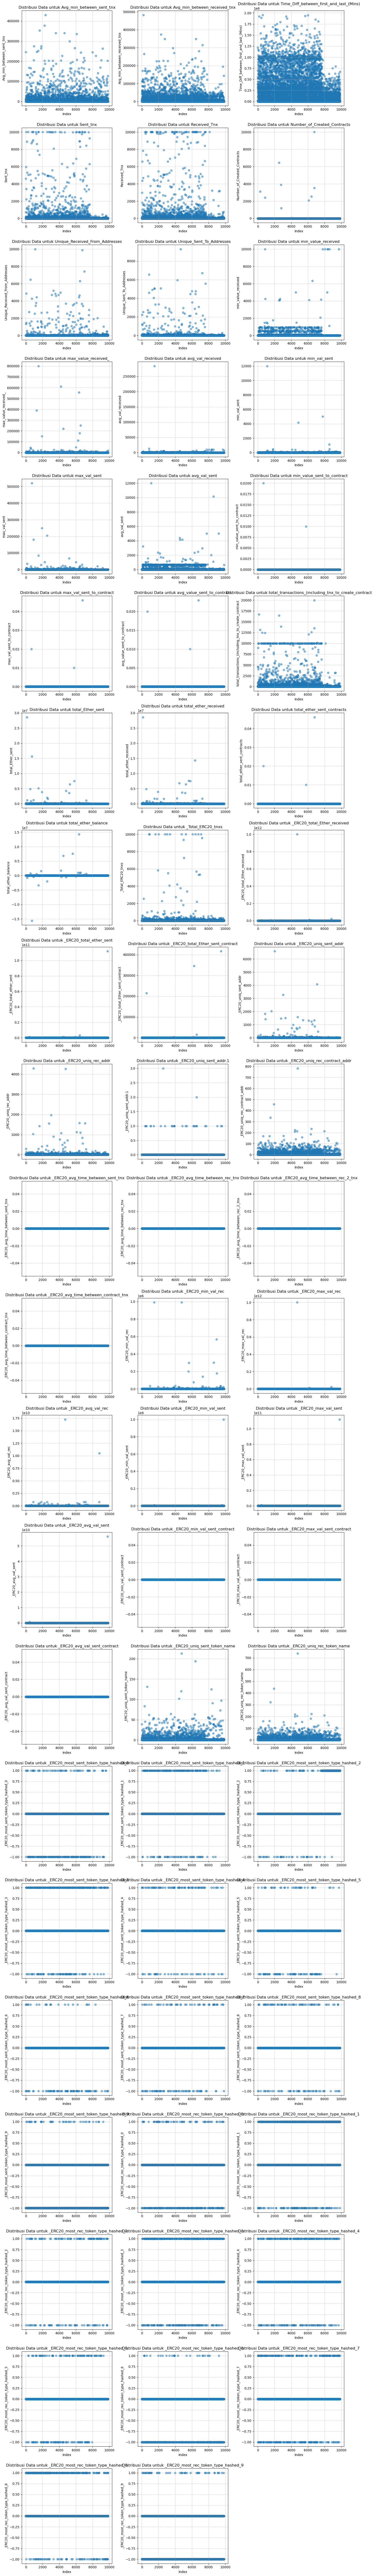

In [48]:
# Visualisasi distribusi fitur numerik
num_cols_in_X = X.select_dtypes(include=['float64', 'int64']).columns
n_plots = len(num_cols_in_X)
n_rows = math.ceil(n_plots / 3)

plt.figure(figsize=(15, 5 * n_rows))
for idx, col in enumerate(num_cols_in_X, 1):
    plt.subplot(n_rows, 3, idx)
    plt.scatter(range(len(X)), X[col], alpha=0.5)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.title(f'Distribusi Data untuk {col}')
    plt.xlabel('Index')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

In [49]:
# 4. Log-transformasi untuk fitur numerik
X_safe = X.copy()
X_safe[num_cols_in_X] = X_safe[num_cols_in_X].apply(lambda col: col.apply(lambda x: x if x > 0 else 0.001))

log_transformer = FunctionTransformer(np.log1p, validate=True)
X_log = log_transformer.fit_transform(X_safe[num_cols_in_X])
X_log = pd.DataFrame(X_log, columns=num_cols_in_X)

# Gabungkan hasil transformasi ke DataFrame X
X[num_cols_in_X] = X_log

In [59]:
skewed_features_after_log = X[num_cols_in_X].apply(lambda col: skew(col))

# Tampilkan hasil
for col, skewness in skewed_features_after_log.items():
    print(f"Skewness untuk {col}: {skewness}")

Skewness untuk Avg_min_between_sent_tnx: 0.6085993000305009
Skewness untuk Avg_min_between_received_tnx: -0.09282050751769265
Skewness untuk Time_Diff_between_first_and_last_(Mins): -0.6601640169827193
Skewness untuk Sent_tnx: 1.531190849181573
Skewness untuk Received_Tnx: 1.230414365840502
Skewness untuk Number_of_Created_Contracts: 12.125031796255753
Skewness untuk Unique_Received_From_Addresses: 2.512112762064343
Skewness untuk Unique_Sent_To_Addresses: 2.1884511315635398
Skewness untuk min_value_received: 1.757015725380996
Skewness untuk max_value_received_: 0.836949393782215
Skewness untuk avg_val_received: 1.129411113100114
Skewness untuk min_val_sent: 2.4746836499691525
Skewness untuk max_val_sent: 0.7785344913734761
Skewness untuk avg_val_sent: 1.0388083384186373
Skewness untuk min_value_sent_to_contract: 80.88225635125289
Skewness untuk max_val_sent_to_contract: 79.57270419773059
Skewness untuk avg_value_sent_to_contract: 64.12116156067572
Skewness untuk total_transactions_(in

C:\Users\ACER\AppData\Local\Temp\ipykernel_23436\2271204308.py:1: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewed_features_after_log = X[num_cols_in_X].apply(lambda col: skew(col))


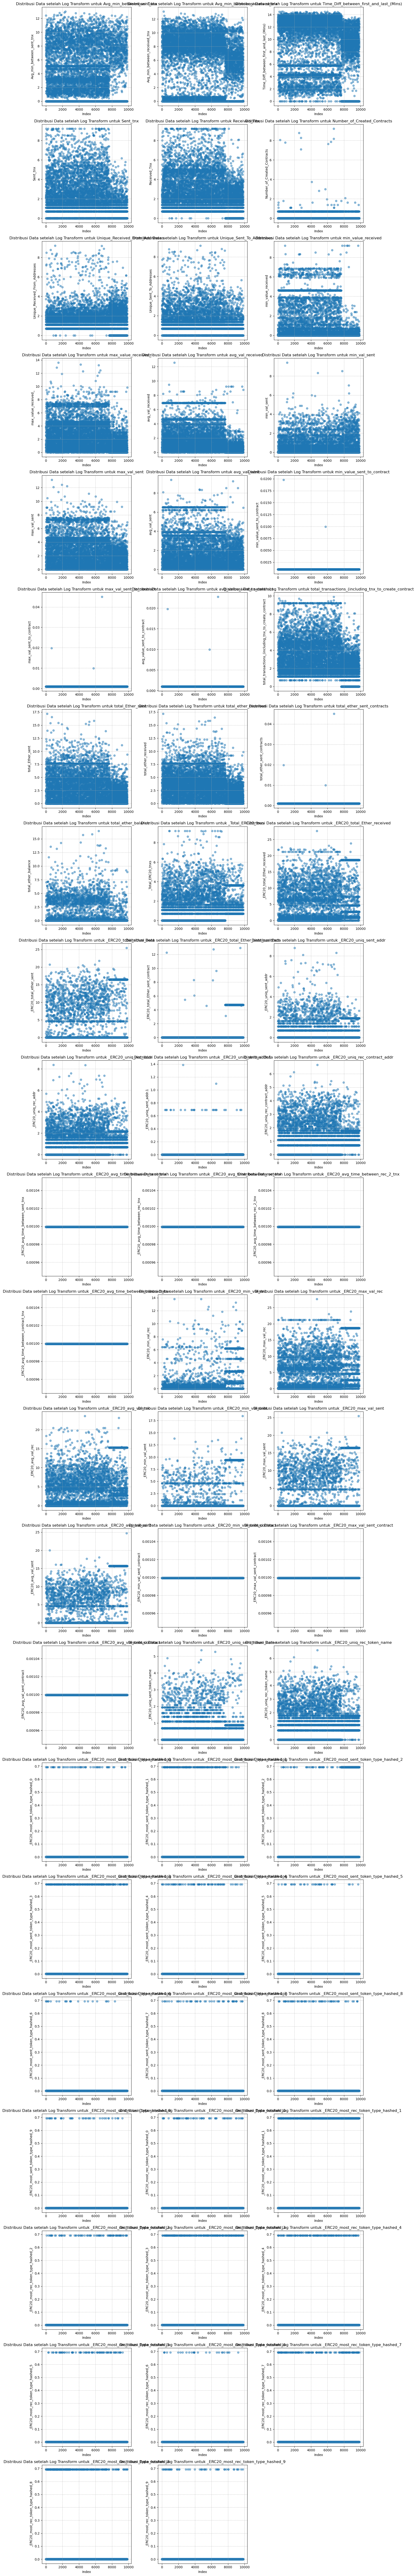

In [51]:
plt.figure(figsize=(15, 5 * n_rows))
for idx, col in enumerate(num_cols_in_X, 1):
    plt.subplot(n_rows, 3, idx)
    plt.scatter(range(len(X_log)), X_log[col], alpha=0.5)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.title(f'Distribusi Data setelah Log Transform untuk {col}')
    plt.xlabel('Index')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

In [52]:
# 5. Sequential Feature Selection (SFS)
model = RandomForestClassifier(random_state=42)  # Gunakan model berbasis estimasi

# Menggunakan SFS untuk memilih fitur terbaik
sfs = SequentialFeatureSelector(
    estimator=model, 
    n_features_to_select=7,  # Sesuaikan jumlah fitur yang ingin dipilih
    direction='forward',  # 'forward' untuk forward selection
    scoring='accuracy',  # Sesuaikan dengan metrik evaluasi yang diinginkan
    cv=5,  # Cross-validation untuk evaluasi
    n_jobs=-1  # Gunakan semua core prosesor yang tersedia
)

sfs.fit(X, y)

SequentialFeatureSelector(estimator=RandomForestClassifier(random_state=42),
                          n_features_to_select=7, n_jobs=-1,
                          scoring='accuracy')

In [53]:
selected_features = X.columns[sfs.get_support()]


# Menampilkan fitur yang dipilih
print("Fitur yang dipilih berdasarkan Sequential Feature Selection:")
for feature in selected_features:
    print(f"Fitur: {feature}")

Fitur yang dipilih berdasarkan Sequential Feature Selection:
Fitur: Time_Diff_between_first_and_last_(Mins)
Fitur: Unique_Received_From_Addresses
Fitur: _Total_ERC20_tnxs
Fitur: _ERC20_uniq_sent_addr
Fitur: _ERC20_min_val_rec
Fitur: _ERC20_uniq_sent_token_name
Fitur: _ERC20_most_sent_token_type_hashed_2


In [54]:
# 6. Menyimpan data dengan fitur yang dipilih
X_selected = X[selected_features]

X_selected.columns

Index(['Time_Diff_between_first_and_last_(Mins)',
       'Unique_Received_From_Addresses', '_Total_ERC20_tnxs',
       '_ERC20_uniq_sent_addr', '_ERC20_min_val_rec',
       '_ERC20_uniq_sent_token_name', '_ERC20_most_sent_token_type_hashed_2'],
      dtype='object')

In [55]:
# 7. Split data menjadi train dan test (80:20)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [56]:
# 8. Oversampling dengan SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
# 9. Standarisasi data sebelum export
# X_train_smote.columns = X_train_smote.columns.str.replace(' ', '_')
# y_train_smote.columns = y_train_smote.columns.str.replace(' ', '_')
# X_test.columns = X_test.columns.str.replace(' ', '_')
# y_test.columns = y_test.columns.str.replace(' ', '_')

# y_train_smote = y_train_smote.values.ravel()
# y_test = y_test.values.ravel()

In [60]:
# 9. Simpan data hasil preprocessing
X_train_smote.to_csv("../../Data/clean/X_train_smote.csv", index=False)
X_test.to_csv("../../Data/clean/X_test.csv", index=False)

# Simpan y_train_smote sebagai array 1 dimensi
np.savetxt("../../Data/clean/y_train_smote.csv", y_train_smote, delimiter=",", fmt='%d')

# Simpan y_test sebagai array 1 dimensi
np.savetxt("../../Data/clean/y_test.csv", y_test, delimiter=",", fmt='%d')

print("Proses selesai. Data oversampling dan fitur yang dipilih telah disimpan.")

Proses selesai. Data oversampling dan fitur yang dipilih telah disimpan.
